# Molecular dynamics from scratch

let's start with a pair of atoms interacting with a Lennard Jones potential function.

$E_{LJ} = 4 \epsilon \left[\left( \frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r} \right)^6 \right]$

in one dimension. Where $r$ is $¦r_i - r_j¦$.

The force on the particles is given by
$F = $

In [1]:
import numpy as np
from ase.io.trajectory import Trajectory
import matplotlib.pyplot as plt

In [2]:
r = np.linspace(2.5,10,100)
epsilon = 0.1
sigma = 3

In [3]:
u = 4*epsilon*((sigma/r)**12-(sigma/r)**6)
fr = 4*epsilon*(12*sigma**12*r**(-13)-6*sigma**6*r**(-7))

(-0.1, 0.1)

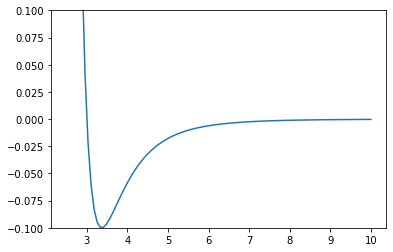

In [4]:
plt.plot(r,u)
plt.ylim(-0.1,0.1)

(-0.1, 0.2)

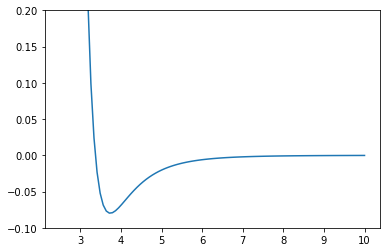

In [5]:
for i in range(100):
    if r[i] > 0: 
        dr = -1.0
    else:
        dr = 1.0

F = - fr * dr

plt.plot(r,F)
plt.ylim(-0.1,0.2)

### Units
the units of the LJ potential are defined by $\epsilon$ - I'd probably use eV for that. $\sigma$ has dimensions of inverse length and cancels the units of $r$ but I'll use $\unicode{xC5}$.

The kinetic energy is given by $\frac{1}{2}m \mathbf{v.v}$. 

## Model Code

In [6]:
from ase import Atoms
from ase.io.trajectory import Trajectory
import numpy as np

In [21]:
box=100
def energyij(model, atomi, atomj):
    """calculates the Lennard Jones potential energy of two particles
    model - model data structure
    atomi - index of atom i
    atomj - index of atom j
    """
    r = np.linalg.norm(model['atoms'][atomi].position - model['atoms'][atomj].position)
    if (r>box):
        {r == r - box}
    u = 4*epsilon*((sigma/r)**12-(sigma/r)**6)
    return u

def forceij(model, atomi, atomj):
    """calculates the Lennard Jones force between two particles
    model - model data structure
    atomi - index of atom i
    atomj - index of atom j
    returns forces on atom i, fi,  and atom j, fj
    """
    #get magnitude and direction of forces - use Newton's 3rd law for fi = -fj 
    r = np.linalg.norm(model['atoms'][atomi].position - model['atoms'][atomj].position)
    if (r>box):
        {r == r - box}
    dir = (model['atoms'][atomi].position - model['atoms'][atomj].position)/r
    #calc force magnitude
    fr = -4*epsilon*(12*sigma**12*r**(-13)-6*sigma**6*r**(-7))
    return -fr*dir, fr*dir

#### setup our model - we'll store everything in a dictionary

In [38]:
nsteps = 2000
dt = 0.1
mass = 1.0
d = 3.3
output_freq = 1
atoms = Atoms('Ar64', positions=[(0.0, 0.0, 0.0),(0.0,0.0,d), (0.0,0.0,2*d), (0.0,0.0,3*d),
                               (d, 0.0, 0.0),(d,0.0,d), (d,0.0,2*d), (d,0.0,3*d),
                               (2*d, 0.0, 0.0),(2*d,0.0,d), (2*d,0.00,2*d), (2*d,0.0,3*d),
                               (3*d, 0.0, 0.0),(3*d,0.0,d), (3*d,0.0,2*d), (3*d,0.0,3*d),
                                 (0.0, d, 0.0),(0.0,d,d), (0.0,d,2*d), (0.0,d,3*d),
                               (d, d, 0.0),(d,d,d), (d,d,2*d), (d,d,3*d),
                               (2*d, d, 0.0),(2*d,d,d), (2*d,d,2*d), (2*d,d,3*d),
                               (3*d, d, 0.0),(3*d,d,d), (3*d,d,2*d), (3*d,d,3*d),
                                (0.0, 2*d, 0.0),(0.0,2*d,d), (0.0,2*d,2*d), (0.0,2*d,3*d),
                               (d, 2*d, 0.0),(d,2*d,d), (d,2*d,2*d), (d,2*d,3*d),
                               (2*d, 2*d, 0.0),(2*d,2*d,d), (2*d,2*d,2*d), (2*d,2*d,3*d),
                               (3*d, 2*d, 0.0),(3*d,2*d,d), (3*d,2*d,2*d), (3*d,2*d,3*d),
                                (0.0, 3*d, 0.0),(0.0,3*d,d), (0.0,3*d,2*d), (0.0,3*d,3*d),
                               (d, 3*d, 0.0),(d,3*d,d), (d,3*d,2*d), (d,3*d,3*d),
                               (2*d, 3*d, 0.0),(2*d,3*d,d), (2*d,3*d,2*d), (2*d,3*d,3*d),
                               (3*d, 3*d, 0.0),(3*d,3*d,d), (3*d,3*d,2*d), (3*d,3*d,3*d)])
#atoms = Atoms('Ar2', positions=[(0.0, 0.0, 0.0),(0.0,0.0,d)])
natoms = len(atoms)
model = dict(natoms = natoms,
             atoms = atoms,
             vel = np.zeros((natoms,3)), 
             forcestp1 = np.zeros((natoms,3)),  
             forcest = np.zeros((natoms,3)),  
             pot_energy = [], 
             KE = [],
             traj = [],
             potential = energyij,
             temp_pos = np.zeros((natoms,3)),
             temp_vel = np.zeros((natoms,3)),
             output_freq = output_freq,
             integrator = 'vverlet'
)

In [39]:
def integrate(model):
    KE = 0
    for atomi in range(model['natoms']):
        if model['integrator'] == 'Euler':
            pot_energy = calcForces(model)
            model['atoms'][atomi].position += model['vel'][atomi]*dt + 0.5*model['forcestp1'][atomi]/mass*dt**2
            model['vel'][atomi] += model['forcestp1'][atomi]/mass*dt

        elif model['integrator'] == 'vverlet':
            model['forcest'] =  np.copy(model['forcestp1'])
            model['atoms'][atomi].position += model['vel'][atomi]*dt + 0.5*model['forcest'][atomi]/mass*dt**2
            pot_energy = calcForces(model)
            model['vel'][atomi] += 0.5*(model['forcest'][atomi]+model['forcestp1'][atomi])/mass*dt            

        else:
            print('no known integrator! falling back on Euler')
            pot_energy = calcForces(model)
            model['atoms'][atomi].position += model['vel'][atomi]*dt + 0.5*model['forcestp1'][atomi]/mass*dt**2
            model['vel'][atomi] += model['forcestp1'][atomi]/mass*dt
            
        KE += np.dot(model['vel'][atomi],model['vel'][atomi])

    return pot_energy, KE

If we have pair potential forces only dependent on the distance, $r_{ij}$ , between a pair of particles we have that
$$
\mathbf{F_i} = \frac{\partial U}{\partial r_{ij}} \cdot \frac{\mathbf{r_{ij}}}{r_{ij}}
$$
and $\mathbf{F_j} = -\mathbf{F_i}$ (Newton's law or due to the change in sign of $\mathbf{r_{ji}}$). 

If we have have multiple particles we should add up all the unique pairs of interactions: 

In [40]:
def calcForces(model):
    energy = 0
    # remember to reset forces at each step
    model['forcestp1'][:] = 0.0
    for atomi in range(model['natoms']):
        #avoid double counting
        for atomj in range(atomi+1, natoms):
            energy += model['potential'](model, atomi, atomj)
            fi, fj = forceij(model,atomi,atomj)
            model['forcestp1'][atomi] += fi
            model['forcestp1'][atomj] += fj
    #print(model['forcestp1'])
    return energy

In [ ]:
# actual MD code
#calc energy / forces
calcForces(model)

for step in range(nsteps):

    # integrate
    pot_energy, KE = integrate(model)
    
    # save data
    model['pot_energy'].append(pot_energy)
    model['KE'].append(0.5*mass*KE)
    if not step%model['output_freq']:
        # need to copy otherwise jwe ust get a pointer to the latest temp_pos
        model['traj'].append(np.copy(model['atoms'].positions))    

In [ ]:
#plt.plot(model['pot_energy'], label='PE')
plt.plot(np.array(model['KE']), label='KE')
#plt.plot(model['pot_energy'] + np.array(model['KE']), label='total')
plt.legend()

## Visualisation

In [ ]:
import nglview as nv

In [36]:
# need to export then reimport at ASE traj ...
# this should go into the dump / output part of the md code
mytraj = Trajectory('mytraj.traj', mode='w')
for traj in model['traj']:
    atoms.positions=traj
    mytraj.write(atoms=atoms)
mytraj.close()
myreadtraj =  Trajectory('mytraj.traj', mode='r')

In [37]:
# viewer - needs ase traj data type
nv.show_asetraj(myreadtraj)

NGLWidget(max_frame=1999)

In [16]:
#v.custom_colors({'O':'green','H':'blue'})
#v.view._remote_call("setSize", target="Widget", args=["400px", "400px"])
#v.view.center()
#v.view.background='white'
#v.view.add_ball_and_stick()
#v.view.parameters=dict(clipDist=-200)

In [17]:
len(myreadtraj)

2000